In [168]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('europe-covid-analysis')
jovian.set_colab_id('1rI4rwuQRrEvev9BPXBO4YMxdjueh-I2a')

In [169]:
!pip install jovian --upgrade --quiet

In [170]:
import jovian

# Italy Covid19 Data Analysis

In this project we will try to train an ML model to predict the outcome of vaccination in Italy. We will rely on [OWIN](https://github.com/owid/covid-19-data) dataset to get the number of new cases, deaths, vaccinations and recoveries. 

The outcome for us means the change in the number of new cases. We are expecting a decrease in number of new deaths after vaccination.  

First of all let's import all the necessary libraries we require for the project.

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import io
import requests

In [172]:
!pip install plotly cufflinks -q


In [173]:
# Import Offline version of plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
import torch.nn as nn

## Data Exploration

The OWIN database maintains recovered count as a separate csv file. So we will download the databases separately and then merge them together into one data frame. 

In [174]:
# Get active case, deaths and vaccination data

covid_tests_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
covid_tests = pd.read_csv(covid_tests_url,error_bad_lines=False)


covid_tests.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
84959,ZWE,Africa,Zimbabwe,2021-04-25,38086.0000,22.0000,47.8570,1557.0000,1.0000,0.5710,2562.4830,1.4800,3.2200,104.7570,0.0670,0.0380,1.0800,nan,nan,nan,nan,nan,nan,nan,nan,1279.0000,482951.0000,32.4940,0.0860,1775.0000,0.1190,0.0270,37.1000,tests performed,390018.0000,336600.0000,53418.0000,17919.0000,10796.0000,2.6200,2.2600,0.3600,726.0000,nan,14862927.0000,42.7290,19.6000,2.8220,1.8820,1899.7750,21.4000,307.8460,1.8200,1.6000,30.7000,36.7910,1.7000,61.4900,0.5710
84960,ZWE,Africa,Zimbabwe,2021-04-26,38102.0000,16.0000,34.7140,1560.0000,3.0000,1.0000,2563.5600,1.0770,2.3360,104.9590,0.2020,0.0670,1.0800,nan,nan,nan,nan,nan,nan,nan,nan,1495.0000,484446.0000,32.5940,0.1010,1722.0000,0.1160,0.0200,49.6000,tests performed,411610.0000,353834.0000,57776.0000,21592.0000,13517.0000,2.7700,2.3800,0.3900,909.0000,nan,14862927.0000,42.7290,19.6000,2.8220,1.8820,1899.7750,21.4000,307.8460,1.8200,1.6000,30.7000,36.7910,1.7000,61.4900,0.5710
84961,ZWE,Africa,Zimbabwe,2021-04-27,38164.0000,62.0000,41.2860,1565.0000,5.0000,1.5710,2567.7310,4.1710,2.7780,105.2960,0.3360,0.1060,1.0900,nan,nan,nan,nan,nan,nan,nan,nan,2355.0000,486801.0000,32.7530,0.1580,1703.0000,0.1150,0.0240,41.2000,tests performed,433939.0000,370676.0000,63263.0000,22329.0000,15562.0000,2.9200,2.4900,0.4300,1047.0000,nan,14862927.0000,42.7290,19.6000,2.8220,1.8820,1899.7750,21.4000,307.8460,1.8200,1.6000,30.7000,36.7910,1.7000,61.4900,0.5710
84962,ZWE,Africa,Zimbabwe,2021-04-28,38191.0000,27.0000,30.1430,1565.0000,0.0000,1.4290,2569.5480,1.8170,2.0280,105.2960,0.0000,0.0960,nan,nan,nan,nan,nan,nan,nan,nan,nan,2025.0000,488826.0000,32.8890,0.1360,1716.0000,0.1150,0.0180,56.9000,tests performed,458013.0000,388021.0000,69992.0000,24074.0000,17860.0000,3.0800,2.6100,0.4700,1202.0000,nan,14862927.0000,42.7290,19.6000,2.8220,1.8820,1899.7750,21.4000,307.8460,1.8200,1.6000,30.7000,36.7910,1.7000,61.4900,0.5710
84963,ZWE,Africa,Zimbabwe,2021-04-29,38235.0000,44.0000,31.0000,1567.0000,2.0000,1.7140,2572.5080,2.9600,2.0860,105.4300,0.1350,0.1150,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,477597.0000,400771.0000,76826.0000,19584.0000,17971.0000,3.2100,2.7000,0.5200,1209.0000,nan,14862927.0000,42.7290,19.6000,2.8220,1.8820,1899.7750,21.4000,307.8460,1.8200,1.6000,30.7000,36.7910,1.7000,61.4900,0.5710


In [175]:
# Filter out data related to Italy

covid_tests=covid_tests[covid_tests['location'].str.contains('Italy')]
covid_tests['date']=pd.to_datetime(covid_tests['date'], format='%Y-%m-%d')
covid_tests.set_index('date', inplace=True)
covid_tests.tail()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-25,ITA,Europe,Italy,3962674.0000,13157.0000,13220.4290,119238.0000,217.0000,330.1430,65540.0960,217.6080,218.6570,1972.1200,3.5890,5.4600,0.9200,2862.0000,47.3360,23524.0000,389.0720,nan,nan,4021.5640,66.5140,239482.0000,57126017.0000,944.8280,3.9610,290225.0000,4.8000,0.0460,22.0000,tests performed,17817630.0000,12595682.0000,5234126.0000,265209.0000,349288.0000,29.4700,20.8300,8.6600,5777.0000,nan,60461828.0000,205.8590,47.9000,23.0210,16.2400,35220.0840,2.0000,113.1510,4.7800,19.8000,27.8000,nan,3.1800,83.5100,0.8920
2021-04-26,ITA,Europe,Italy,3971114.0000,8440.0000,13160.0000,119539.0000,301.0000,328.0000,65679.6880,139.5920,217.6580,1977.0990,4.9780,5.4250,0.9200,nan,nan,nan,nan,nan,nan,nan,nan,145819.0000,57271836.0000,947.2400,2.4120,290095.0000,4.7980,0.0450,22.0000,tests performed,18157655.0000,12854735.0000,5324283.0000,340025.0000,353868.0000,30.0300,21.2600,8.8100,5853.0000,nan,60461828.0000,205.8590,47.9000,23.0210,16.2400,35220.0840,2.0000,113.1510,4.7800,19.8000,27.8000,nan,3.1800,83.5100,0.8920
2021-04-27,ITA,Europe,Italy,3981512.0000,10398.0000,12921.2860,119912.0000,373.0000,325.5710,65851.6640,171.9760,213.7100,1983.2680,6.1690,5.3850,0.9100,nan,nan,nan,nan,nan,nan,nan,nan,302734.0000,57574570.0000,952.2470,5.0070,291336.0000,4.8190,0.0440,22.5000,tests performed,18522804.0000,13110491.0000,5441282.0000,365149.0000,358845.0000,30.6400,21.6800,9.0000,5935.0000,nan,60461828.0000,205.8590,47.9000,23.0210,16.2400,35220.0840,2.0000,113.1510,4.7800,19.8000,27.8000,nan,3.1800,83.5100,0.8920
2021-04-28,ITA,Europe,Italy,3994894.0000,13382.0000,12856.4290,120256.0000,344.0000,322.7140,66072.9940,221.3300,212.6370,1988.9570,5.6900,5.3370,nan,nan,nan,nan,nan,nan,nan,nan,nan,336336.0000,57910906.0000,957.8090,5.5630,289379.0000,4.7860,0.0440,22.5000,tests performed,18920622.0000,13372589.0000,5584776.0000,397818.0000,362883.0000,31.2900,22.1200,9.2400,6002.0000,nan,60461828.0000,205.8590,47.9000,23.0210,16.2400,35220.0840,2.0000,113.1510,4.7800,19.8000,27.8000,nan,3.1800,83.5100,0.8920
2021-04-29,ITA,Europe,Italy,4009208.0000,14314.0000,12609.0000,120544.0000,288.0000,312.4290,66309.7380,236.7440,208.5450,1993.7210,4.7630,5.1670,nan,nan,nan,nan,nan,nan,nan,nan,nan,330075.0000,58240981.0000,963.2690,5.4590,284418.0000,4.7040,0.0440,22.6000,tests performed,19418615.0000,13707390.0000,5756729.0000,497993.0000,377864.0000,32.1200,22.6700,9.5200,6250.0000,nan,60461828.0000,205.8590,47.9000,23.0210,16.2400,35220.0840,2.0000,113.1510,4.7800,19.8000,27.8000,nan,3.1800,83.5100,0.8920


In [176]:
# Get recovery data 

covid_recovery_url = 'https://raw.githubusercontent.com/datasets/covid-19/main/data/time-series-19-covid-combined.csv'
covid_recovery = pd.read_csv(covid_recovery_url,error_bad_lines=False)
covid_recovery['Date']=pd.to_datetime(covid_recovery['Date'], format='%Y-%m-%d')
covid_recovery.set_index('Date',inplace=True)

# Filter out Italy data
covid_recovery=covid_recovery[covid_recovery['Country/Region'].str.contains('Italy')]
covid_recovery.tail()

,Country/Region,Province/State,Confirmed,Recovered,Deaths
Date,,,,,
2021-04-25,Italy,NaN,3962674,3382224.0000,119238
2021-04-26,Italy,NaN,3971114,3398763.0000,119539
2021-04-27,Italy,NaN,3981512,3413451.0000,119912
2021-04-28,Italy,NaN,3994894,3431867.0000,120256
2021-04-29,Italy,NaN,4009208,3449955.0000,120544


In [177]:
# Meriging and filtering out useful data

dfI = covid_tests
dfI['total_recoveries'] = covid_recovery['Recovered']
dfI = dfI[['new_cases', 'total_cases', 'new_deaths', 'total_deaths','new_vaccinations','total_vaccinations','total_recoveries']]
dfI['new_recoveries'] = dfI['total_recoveries'].shift(-1) - dfI['total_recoveries']
dfI.fillna(method='ffill', inplace=True)
dfI

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations,total_vaccinations,total_recoveries,new_recoveries
date,,,,,,,,
2020-01-31,2.0000,2.0000,nan,nan,nan,nan,0.0000,0.0000
2020-02-01,0.0000,2.0000,nan,nan,nan,nan,0.0000,0.0000
2020-02-02,0.0000,2.0000,nan,nan,nan,nan,0.0000,0.0000
2020-02-03,0.0000,2.0000,nan,nan,nan,nan,0.0000,0.0000
2020-02-04,0.0000,2.0000,nan,nan,nan,nan,0.0000,0.0000
...,...,...,...,...,...,...,...,...
2021-04-25,13157.0000,3962674.0000,217.0000,119238.0000,265209.0000,17817630.0000,3382224.0000,16539.0000
2021-04-26,8440.0000,3971114.0000,301.0000,119539.0000,340025.0000,18157655.0000,3398763.0000,14688.0000
2021-04-27,10398.0000,3981512.0000,373.0000,119912.0000,365149.0000,18522804.0000,3413451.0000,18416.0000


In [178]:
arrI = ['new_cases','new_deaths','new_recoveries']
for i in arrI:
  print(dfI[i].mean(),dfI[i].std(),dfI[i].max())

8811.446153846155 9804.805332758204 40902.0
277.7511520737327 247.24460835629202 993.0
7622.072527472527 9024.268195720719 39266.0


In [179]:
fig = make_subplots(rows=4, 
                    cols=2, 
#                    print_grid=True,
                    subplot_titles=("New Cases", "Total Cases", "New Deaths", "Total Deaths", "New Vaccination", "Total Vaccination", 'New Recoveries',"Total Recoveries"))

graphs = [
          go.Scatter(x=dfI.index,y=dfI['new_cases'], marker_color='blue'),
          go.Scatter(x=dfI.index,y=dfI['total_cases'],marker_color='blue'),
          go.Scatter(x=dfI.index,y=dfI['new_deaths'],marker_color='red'),
          go.Scatter(x=dfI.index,y=dfI['total_deaths'],marker_color='red'),
          go.Scatter(x=dfI.index,y=dfI['new_vaccinations'],marker_color='yellow'),
          go.Scatter(x=dfI.index,y=dfI['total_vaccinations'],marker_color='yellow'),
          go.Scatter(x=dfI.index,y=dfI['new_recoveries'],marker_color='green'),
          go.Scatter(x=dfI.index,y=dfI['total_recoveries'],marker_color='green'),
        ]

for i in range(0,int(len(graphs)/2)):
  for j in range(0,2):
    print(1+j)
    fig.add_trace(
      graphs[2*i+j],
      row=i+1, 
      col=1+j
    )

fig.update_layout(title_text="Italy Data", height=1000)

fig.show(renderer='colab')

1
2
1
2
1
2
1
2


### Observations

Italy has gone through 3 waves of covid 19 as seen from the plot of new cases. The first wave occured during March 2020, second wave during November 2020 and third wave during March 2021 and is on a decling slope now. 

It is interesting to note that the new cases during the second wave were close to seven times that of the first wave but the number of new deaths did not increase at that rate and remained below 1000. 

The new vaccination rate is somewhat exponential which triggered around March 1, 2021. 

The number of recoveries per day has also been increased by 7 folds during second wave than the first one. 

An estimated range of dates for the three waves in Italy can be as follows-

|    Wave     |     Start   |    End    |
| ----------- | ----------- |-----------|
| Wave 1      | Mar 1, 2020 |June 30, 2020|
| Wave 2      |Aug 28, 2020 |Feb 2, 2021|
| Wave 3      |Feb 2, 2021  |April 30, 2021| 






In [180]:
# No of days in future we want to make our prediction
period = 200

## Prior

The spread of pandemic is exponential but it cannot cover the whole population hence will eventually form a sigmoid curve over the total cases. 

## Facebook's prophet for predicting the future

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.


In [181]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly


dfI['ds'] = pd.to_datetime(dfI.index)
dfI['y'] = dfI.total_cases

dfI.tail()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations,total_vaccinations,total_recoveries,new_recoveries,ds,y
date,,,,,,,,,,
2021-04-25,13157.0000,3962674.0000,217.0000,119238.0000,265209.0000,17817630.0000,3382224.0000,16539.0000,2021-04-25,3962674.0000
2021-04-26,8440.0000,3971114.0000,301.0000,119539.0000,340025.0000,18157655.0000,3398763.0000,14688.0000,2021-04-26,3971114.0000
2021-04-27,10398.0000,3981512.0000,373.0000,119912.0000,365149.0000,18522804.0000,3413451.0000,18416.0000,2021-04-27,3981512.0000
2021-04-28,13382.0000,3994894.0000,344.0000,120256.0000,397818.0000,18920622.0000,3431867.0000,18088.0000,2021-04-28,3994894.0000
2021-04-29,14314.0000,4009208.0000,288.0000,120544.0000,497993.0000,19418615.0000,3449955.0000,18088.0000,2021-04-29,4009208.0000


In [182]:
m = Prophet(interval_width=0.95,daily_seasonality=True)
m.fit(dfI)
future = m.make_future_dataframe(periods=period)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds
650,2021-11-11
651,2021-11-12
652,2021-11-13
653,2021-11-14
654,2021-11-15


In [183]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
650,2021-11-11,7495900.3222,4190662.1033,10839550.9072,4192595.2032,10829344.6606,-4207.8309,-4207.8309,-4207.8309,-3434.4758,-3434.4758,-3434.4758,-773.3551,-773.3551,-773.3551,0.0000,0.0000,0.0000,7491692.4913
651,2021-11-12,7513468.3162,4175314.6659,10877269.2080,4176842.8020,10869007.4010,-2132.4944,-2132.4944,-2132.4944,-3434.4758,-3434.4758,-3434.4758,1301.9814,1301.9814,1301.9814,0.0000,0.0000,0.0000,7511335.8218
652,2021-11-13,7531036.3103,4144737.0928,10929996.4164,4160525.8770,10915831.1595,-1220.0193,-1220.0193,-1220.0193,-3434.4758,-3434.4758,-3434.4758,2214.4566,2214.4566,2214.4566,0.0000,0.0000,0.0000,7529816.2910
653,2021-11-14,7548604.3043,4166808.6464,11009796.0766,4152555.9433,10963665.5029,-1431.7373,-1431.7373,-1431.7373,-3434.4758,-3434.4758,-3434.4758,2002.7385,2002.7385,2002.7385,0.0000,0.0000,0.0000,7547172.5670
654,2021-11-15,7566172.2983,4130907.5560,11021902.3235,4157127.9533,11010805.3234,-4091.5562,-4091.5562,-4091.5562,-3434.4758,-3434.4758,-3434.4758,-657.0804,-657.0804,-657.0804,0.0000,0.0000,0.0000,7562080.7421


In [184]:
plot_plotly(m, forecast)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


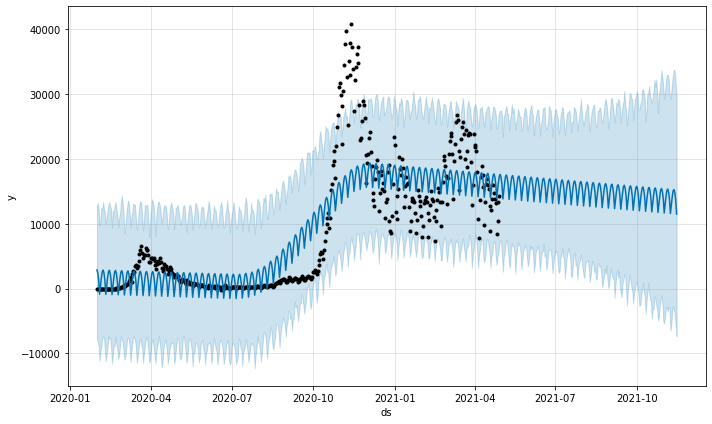

In [185]:
dfI['y'] = dfI.new_cases
m = Prophet(interval_width=0.95)
m.fit(dfI)
future = m.make_future_dataframe(periods=period)
forecast_new_cases = m.predict(future)
confirmed_forecast_plot = m.plot(forecast_new_cases)

We can see the facebook's prophet gave a reasonable result on total_cases but somewhat failed to predict the new cases which is expected as prophet works by finding a seasonality trend in data which is not the case with new_cases data.

In [186]:
# Running prophet on total_deaths, total_vaccination and total_recoveries

arr = ['total_cases','total_deaths','total_vaccinations','total_recoveries']
predictions = []
forecast = []

for i in range(len(arr)):
  dfI['y'] = dfI[arr[i]]
  m = Prophet(interval_width=0.95,daily_seasonality=True)
  m.fit(dfI)
  future = m.make_future_dataframe(periods=period)
  forecast.append(m.predict(future))
  predictions.append(m)

  
plot_plotly(predictions[0], forecast[0],ylabel=arr[0]) 
                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarni

In [187]:
plot_plotly(predictions[1], forecast[1],ylabel=arr[1]) 


In [188]:
plot_plotly(predictions[2], forecast[2],ylabel=arr[2]) 


In [189]:
plot_plotly(predictions[3], forecast[3],ylabel=arr[3]) 

## polynomial regression model


In [190]:
days = list(range(0,len(dfI.index)))
days

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [191]:
dfI['days'] = days
dfI.tail(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations,total_vaccinations,total_recoveries,new_recoveries,ds,y,days
date,,,,,,,,,,,
2021-04-25,13157.0000,3962674.0000,217.0000,119238.0000,265209.0000,17817630.0000,3382224.0000,16539.0000,2021-04-25,3382224.0000,450
2021-04-26,8440.0000,3971114.0000,301.0000,119539.0000,340025.0000,18157655.0000,3398763.0000,14688.0000,2021-04-26,3398763.0000,451
2021-04-27,10398.0000,3981512.0000,373.0000,119912.0000,365149.0000,18522804.0000,3413451.0000,18416.0000,2021-04-27,3413451.0000,452
2021-04-28,13382.0000,3994894.0000,344.0000,120256.0000,397818.0000,18920622.0000,3431867.0000,18088.0000,2021-04-28,3431867.0000,453
2021-04-29,14314.0000,4009208.0000,288.0000,120544.0000,497993.0000,19418615.0000,3449955.0000,18088.0000,2021-04-29,3449955.0000,454


In [192]:
dateI = dfI.index
dateI

DatetimeIndex(['2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03',
               '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
               '2020-02-08', '2020-02-09',
               ...
               '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23',
               '2021-04-24', '2021-04-25', '2021-04-26', '2021-04-27',
               '2021-04-28', '2021-04-29'],
              dtype='datetime64[ns]', name='date', length=455, freq=None)

In [193]:
dfI['Day']=dateI.day
dfI['week']=dateI.week
dfI['month']=dateI.month
dfI['year']=dateI.year
dfI['total_recoveries'].fillna(0, inplace=True)
dfI['new_recoveries'].fillna(0, inplace=True)
#dfI['total_vaccinations'].iloc(-1)
dfI['total_vaccinations'].fillna(0, inplace=True)
dfI['total_deaths'].fillna(0, inplace=True)
dfI['new_recoveries'].fillna(0, inplace=True)
dfI.fillna(dfI.mean(), inplace=True)
dfI.tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

,new_cases,total_cases,new_deaths,total_deaths,new_vaccinations,total_vaccinations,total_recoveries,new_recoveries,ds,y,days,Day,week,month,year
date,,,,,,,,,,,,,,,
2021-04-20,12069.0000,3891063.0000,390.0000,117633.0000,330310.0000,16010891.0000,3290715.0000,20552.0000,2021-04-20,3290715.0000,445,20,16,4,2021
2021-04-21,13836.0000,3904899.0000,364.0000,117997.0000,369552.0000,16380443.0000,3311267.0000,19125.0000,2021-04-21,3311267.0000,446,21,16,4,2021
2021-04-22,16046.0000,3920945.0000,360.0000,118357.0000,393121.0000,16773564.0000,3330392.0000,21069.0000,2021-04-22,3330392.0000,447,22,16,4,2021
2021-04-23,14758.0000,3935703.0000,342.0000,118699.0000,398401.0000,17171965.0000,3351461.0000,17587.0000,2021-04-23,3351461.0000,448,23,16,4,2021
2021-04-24,13814.0000,3949517.0000,322.0000,119021.0000,380456.0000,17552421.0000,3369048.0000,13176.0000,2021-04-24,3369048.0000,449,24,16,4,2021
2021-04-25,13157.0000,3962674.0000,217.0000,119238.0000,265209.0000,17817630.0000,3382224.0000,16539.0000,2021-04-25,3382224.0000,450,25,16,4,2021
2021-04-26,8440.0000,3971114.0000,301.0000,119539.0000,340025.0000,18157655.0000,3398763.0000,14688.0000,2021-04-26,3398763.0000,451,26,17,4,2021
2021-04-27,10398.0000,3981512.0000,373.0000,119912.0000,365149.0000,18522804.0000,3413451.0000,18416.0000,2021-04-27,3413451.0000,452,27,17,4,2021
2021-04-28,13382.0000,3994894.0000,344.0000,120256.0000,397818.0000,18920622.0000,3431867.0000,18088.0000,2021-04-28,3431867.0000,453,28,17,4,2021


In [194]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures
from datetime import timedelta


### total_cases


In [195]:
array_types = ["cases", "deaths", "vaccinations"]
index=0

In [196]:

train_ml=dfI.iloc[:int(dfI.shape[0]*0.95)]             #spliting our dataset to train and testing sets
test_ml=dfI.iloc[int(dfI.shape[0]*0.95):]
#TRYING FOR DIFFERENT DEGREE'S
for i in range(2,9):
  model_scores=[]
  poly = PolynomialFeatures(degree =i) 

  train_poly=poly.fit_transform(np.array(train_ml["days"]).reshape(-1,1))
  test_poly=poly.fit_transform(np.array(test_ml["days"]).reshape(-1,1))
  y=train_ml["total_"+array_types[index]]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)

  prediction_poly=linreg.predict(test_poly)
  rmse_poly=np.sqrt(mean_squared_error(test_ml["total_"+array_types[index]],prediction_poly))
  model_scores.append(rmse_poly)
  print("Root Mean Squared Error for Polynomial Regression for "f"{i}"" degree: ",rmse_poly)

  computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
  plt.figure(figsize=(10,5))
  predictions_poly=linreg.predict(computing_data)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
  fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
  fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction for ",
                 xaxis_title="Days",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
  fig.show()

Root Mean Squared Error for Polynomial Regression for 2 degree:  195855.25003892268


Root Mean Squared Error for Polynomial Regression for 3 degree:  464660.9041303955


Root Mean Squared Error for Polynomial Regression for 4 degree:  208087.4070931402


Root Mean Squared Error for Polynomial Regression for 5 degree:  577785.7570096686


Root Mean Squared Error for Polynomial Regression for 6 degree:  268504.7701298989


Root Mean Squared Error for Polynomial Regression for 7 degree:  1142997.1586232036


Root Mean Squared Error for Polynomial Regression for 8 degree:  980910.7387688197


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [197]:
model_scores=[]
poly = PolynomialFeatures(degree =8) 

train_poly=poly.fit_transform(np.array(train_ml["days"]).reshape(-1,1))
test_poly=poly.fit_transform(np.array(test_ml["days"]).reshape(-1,1))
y=train_ml["total_"+array_types[index]]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

prediction_poly=linreg.predict(test_poly)
rmse_poly=np.sqrt(mean_squared_error(test_ml["total_"+array_types[index]],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
plt.figure(figsize=(10,5))
predictions_poly=linreg.predict(computing_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Days",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Root Mean Squared Error for Polynomial Regression:  980910.7387688197


<Figure size 720x360 with 0 Axes>

In [198]:
new_prediction_poly=[]
new_date=[]
for i in range(1,60):
    new_date.append(dfI.index[-1]+timedelta(days=i))
    new_date_poly=poly.fit_transform(np.array(dfI["days"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [199]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_poly),
                               columns=["Dates","Polynonmial Regression Prediction"])
model_predictions.head(25)

,Dates,Polynonmial Regression Prediction
0,2021-04-30,5898041.1421
1,2021-05-01,6027806.1697
2,2021-05-02,6162171.3090
3,2021-05-03,6301261.5286
4,2021-05-04,6445203.9575
5,2021-05-05,6594127.9048
6,2021-05-06,6748164.8794
7,2021-05-07,6907448.6104
8,2021-05-08,7072115.0668
9,2021-05-09,7242302.4774


In [200]:
#prediction for next 30 days
#using ploynomial regression
computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
plt.figure(figsize=(10,5))
predictions_poly=linreg.predict(computing_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions['Polynonmial Regression Prediction'],
                    mode='lines',name="Polynomial Regression Best Fit for next 30 days",
                    line=dict(color='red', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Days",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 720x360 with 0 Axes>

### total_deaths



In [201]:
array_types = ["cases", "deaths", "vaccinations"]
index=1

In [202]:

train_ml=dfI.iloc[:int(dfI.shape[0]*0.95)]             #spliting our dataset to train and testing sets
test_ml=dfI.iloc[int(dfI.shape[0]*0.95):]
#TRYING FOR DIFFERENT DEGREE'S
for i in range(2,9):
  model_scores=[]
  poly = PolynomialFeatures(degree =i) 

  train_poly=poly.fit_transform(np.array(train_ml["days"]).reshape(-1,1))
  test_poly=poly.fit_transform(np.array(test_ml["days"]).reshape(-1,1))
  y=train_ml["total_"+array_types[index]]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)

  prediction_poly=linreg.predict(test_poly)
  rmse_poly=np.sqrt(mean_squared_error(test_ml["total_"+array_types[index]],prediction_poly))
  model_scores.append(rmse_poly)
  print("Root Mean Squared Error for Polynomial Regression for "f"{i}"" degree: ",rmse_poly)

  computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
  plt.figure(figsize=(10,5))
  predictions_poly=linreg.predict(computing_data)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for total deaths"))
  fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
  fig.update_layout(title="Deaths Polynomial Regression Prediction for ",
                 xaxis_title="Days",yaxis_title="Deaths",
                 legend=dict(x=0,y=1,traceorder="normal"))
  fig.show()

Root Mean Squared Error for Polynomial Regression for 2 degree:  3244.9379517044663


Root Mean Squared Error for Polynomial Regression for 3 degree:  18582.974789916043


Root Mean Squared Error for Polynomial Regression for 4 degree:  2989.941701367448


Root Mean Squared Error for Polynomial Regression for 5 degree:  25437.98423458754


Root Mean Squared Error for Polynomial Regression for 6 degree:  4894.652484046294


Root Mean Squared Error for Polynomial Regression for 7 degree:  4606.7847953886785


Root Mean Squared Error for Polynomial Regression for 8 degree:  22816.445920265753


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [203]:
model_scores=[]
poly = PolynomialFeatures(degree =4) 

train_poly=poly.fit_transform(np.array(train_ml["days"]).reshape(-1,1))
test_poly=poly.fit_transform(np.array(test_ml["days"]).reshape(-1,1))
y=train_ml["total_"+array_types[index]]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

prediction_poly=linreg.predict(test_poly)
rmse_poly=np.sqrt(mean_squared_error(test_ml["total_"+array_types[index]],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
plt.figure(figsize=(10,5))
predictions_poly=linreg.predict(computing_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for Deaths"))
fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Deaths Polynomial Regression Prediction",
                 xaxis_title="Days",yaxis_title="Deaths",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Root Mean Squared Error for Polynomial Regression:  2989.941701367448


<Figure size 720x360 with 0 Axes>

In [204]:
new_prediction_poly=[]
new_date=[]
for i in range(1,60):
    new_date.append(dfI.index[-1]+timedelta(days=i))
    new_date_poly=poly.fit_transform(np.array(dfI["days"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [205]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_poly),
                               columns=["Dates","Polynonmial Regression Prediction"])
model_predictions.head(25)

,Dates,Polynonmial Regression Prediction
0,2021-04-30,124162.8019
1,2021-05-01,124489.4856
2,2021-05-02,124811.1347
3,2021-05-03,125127.6638
4,2021-05-04,125438.9873
5,2021-05-05,125745.0188
6,2021-05-06,126045.6716
7,2021-05-07,126340.8586
8,2021-05-08,126630.4923
9,2021-05-09,126914.4844


In [206]:
#prediction for next 30 days
#using ploynomial regression
computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
plt.figure(figsize=(10,5))
predictions_poly=linreg.predict(computing_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for Deaths"))
fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions['Polynonmial Regression Prediction'],
                    mode='lines',name="Polynomial Regression Best Fit for next 30 days",
                    line=dict(color='red', dash='dot')))
fig.update_layout(title="Deaths Polynomial Regression Prediction",
                 xaxis_title="Days",yaxis_title="Deaths",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 720x360 with 0 Axes>

### total_vaccinations


In [207]:
array_types = ["cases", "deaths", "vaccinations"]
index=2

In [208]:

train_ml=dfI.iloc[:int(dfI.shape[0]*0.95)]             #spliting our dataset to train and testing sets
test_ml=dfI.iloc[int(dfI.shape[0]*0.95):]
#TRYING FOR DIFFERENT DEGREE'S
for i in range(2,9):
  model_scores=[]
  poly = PolynomialFeatures(degree =i) 

  train_poly=poly.fit_transform(np.array(train_ml["days"]).reshape(-1,1))
  test_poly=poly.fit_transform(np.array(test_ml["days"]).reshape(-1,1))
  y=train_ml["total_"+array_types[index]]

  linreg=LinearRegression(normalize=True)
  linreg.fit(train_poly,y)

  prediction_poly=linreg.predict(test_poly)
  rmse_poly=np.sqrt(mean_squared_error(test_ml["total_"+array_types[index]],prediction_poly))
  model_scores.append(rmse_poly)
  print("Root Mean Squared Error for Polynomial Regression for "f"{i}"" degree: ",rmse_poly)

  computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
  plt.figure(figsize=(10,5))
  predictions_poly=linreg.predict(computing_data)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for total vaccinations"))
  fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
  fig.update_layout(title="Total Vaccinations Cases Polynomial Regression Prediction for ",
                 xaxis_title="Days",yaxis_title="Total Vaccinations",
                 legend=dict(x=0,y=1,traceorder="normal"))
  fig.show()

Root Mean Squared Error for Polynomial Regression for 2 degree:  8461435.040272642


Root Mean Squared Error for Polynomial Regression for 3 degree:  4688543.261584016


Root Mean Squared Error for Polynomial Regression for 4 degree:  1709709.1845237722


Root Mean Squared Error for Polynomial Regression for 5 degree:  143508.57328875625


Root Mean Squared Error for Polynomial Regression for 6 degree:  83903.17305595001


Root Mean Squared Error for Polynomial Regression for 7 degree:  356481.4641993105


Root Mean Squared Error for Polynomial Regression for 8 degree:  330242.07324865414


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [209]:
model_scores=[]
poly = PolynomialFeatures(degree =5) 

train_poly=poly.fit_transform(np.array(train_ml["days"]).reshape(-1,1))
test_poly=poly.fit_transform(np.array(test_ml["days"]).reshape(-1,1))
y=train_ml["total_"+array_types[index]]

linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

prediction_poly=linreg.predict(test_poly)
rmse_poly=np.sqrt(mean_squared_error(test_ml["total_"+array_types[index]],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
plt.figure(figsize=(10,5))
predictions_poly=linreg.predict(computing_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for total vaccinations"))
fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Total Vaccinations Polynomial Regression Prediction",
                 xaxis_title="Days",yaxis_title="Total Vaccinations",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Root Mean Squared Error for Polynomial Regression:  143508.57328875625


<Figure size 720x360 with 0 Axes>

In [210]:
new_prediction_poly=[]
new_date=[]
for i in range(1,60):
    new_date.append(dfI.index[-1]+timedelta(days=i))
    new_date_poly=poly.fit_transform(np.array(dfI["days"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [211]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_poly),
                               columns=["Dates","Polynonmial Regression Prediction"])
model_predictions.head(25)

,Dates,Polynonmial Regression Prediction
0,2021-04-30,19514623.7567
1,2021-05-01,19905245.9471
2,2021-05-02,20301797.8160
3,2021-05-03,20704343.7215
4,2021-05-04,21112948.4679
5,2021-05-05,21527677.3077
6,2021-05-06,21948595.9425
7,2021-05-07,22375770.5247
8,2021-05-08,22809267.6592
9,2021-05-09,23249154.4046


In [212]:
#prediction for next 30 days
#using ploynomial regression
computing_data=poly.fit_transform(np.array(dfI["days"]).reshape(-1,1))
plt.figure(figsize=(10,5))
predictions_poly=linreg.predict(computing_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for total vaccinations"))
fig.add_trace(go.Scatter(x=dfI.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions['Polynonmial Regression Prediction'],
                    mode='lines',name="Polynomial Regression Best Fit for next 30 days",
                    line=dict(color='red', dash='dot')))
fig.update_layout(title="Total Vaccinations Polynomial Regression Prediction",
                 xaxis_title="Days",yaxis_title="total vaccinations",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 720x360 with 0 Axes>

## holt linear model


In [213]:
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet

### total cases


In [214]:
index = 0

In [215]:
train_ml=dfI.iloc[:int(dfI.shape[0]*0.95)]
test_ml=dfI.iloc[int(dfI.shape[0]*0.95):]

y_pred=test_ml.copy()
model_scores=[]

holt=Holt(np.asarray(train_ml["total_"+array_types[index]])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False) 

y_pred["Holt"]=holt.forecast(len(test_ml))
model_scores.append(np.sqrt(mean_squared_error(y_pred["total_"+array_types[index]],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["total_"+array_types[index]],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  31868.041710024918


In [216]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_ml.index, y=train_ml["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for "+array_types[index]))

fig.add_trace(go.Scatter(x=test_ml.index, y=test_ml["total_"+array_types[index]],
                    mode='lines+markers',name="Validation Data for "+array_types[index],))

fig.add_trace(go.Scatter(x=test_ml.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of "+array_types[index]))

fig.update_layout(title=array_types[index]+" Holt's Linear Model Prediction",
                 xaxis_title="Days",yaxis_title=array_types[index],legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [217]:
#making prediction for next 30 days
holt_new_prediction=[]
for i in range(1,60):
    holt_new_prediction.append(holt.forecast((len(test_ml)+i))[-1])
model_predictions["Holt Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Polynonmial Regression Prediction,Holt Linear Model Prediction
0,2021-04-30,19514623.7567,4084688.1967
1,2021-05-01,19905245.9471,4100846.2668
2,2021-05-02,20301797.8160,4117004.3369
3,2021-05-03,20704343.7215,4133162.4070
4,2021-05-04,21112948.4679,4149320.4771


In [218]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for "+array_types[index]))

fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions['Holt Linear Model Prediction'],
                    mode='lines',name="Prediction for next 60 days",
                    line=dict(color='blue', dash='dot')))

fig.update_layout(title=array_types[index]+" Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title=array_types[index],legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### total deaths


In [219]:
index = 1

In [220]:
train_ml=dfI.iloc[:int(dfI.shape[0]*0.95)]
test_ml=dfI.iloc[int(dfI.shape[0]*0.95):]

y_pred=test_ml.copy()
model_scores=[]

holt=Holt(np.asarray(train_ml["total_"+array_types[index]])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False) 

y_pred["Holt"]=holt.forecast(len(test_ml))
model_scores.append(np.sqrt(mean_squared_error(y_pred["total_"+array_types[index]],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["total_"+array_types[index]],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  470.9905131886708


In [221]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_ml.index, y=train_ml["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for "+array_types[index]))

fig.add_trace(go.Scatter(x=test_ml.index, y=test_ml["total_"+array_types[index]],
                    mode='lines+markers',name="Validation Data for "+array_types[index],))

fig.add_trace(go.Scatter(x=test_ml.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of "+array_types[index]))

fig.update_layout(title=array_types[index]+" Holt's Linear Model Prediction",
                 xaxis_title="Days",yaxis_title=array_types[index],legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [222]:
#making prediction for next 30 days
holt_new_prediction=[]
for i in range(1,60):
    holt_new_prediction.append(holt.forecast((len(test_ml)+i))[-1])
model_predictions["Holt Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Polynonmial Regression Prediction,Holt Linear Model Prediction
0,2021-04-30,19514623.7567,120970.1440
1,2021-05-01,19905245.9471,121351.4768
2,2021-05-02,20301797.8160,121732.8095
3,2021-05-03,20704343.7215,122114.1423
4,2021-05-04,21112948.4679,122495.4751


In [223]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for "+array_types[index]))

fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions['Holt Linear Model Prediction'],
                    mode='lines',name="Prediction for next 60 days",
                    line=dict(color='blue', dash='dot')))

fig.update_layout(title=array_types[index]+" Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title=array_types[index],legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### total vaccinations


In [224]:
index = 1

In [225]:
train_ml=dfI.iloc[:int(dfI.shape[0]*0.95)]
test_ml=dfI.iloc[int(dfI.shape[0]*0.95):]

y_pred=test_ml.copy()
model_scores=[]

holt=Holt(np.asarray(train_ml["total_"+array_types[index]])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False) 

y_pred["Holt"]=holt.forecast(len(test_ml))
model_scores.append(np.sqrt(mean_squared_error(y_pred["total_"+array_types[index]],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["total_"+array_types[index]],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  470.9905131886708


In [226]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_ml.index, y=train_ml["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for "+array_types[index]))

fig.add_trace(go.Scatter(x=test_ml.index, y=test_ml["total_"+array_types[index]],
                    mode='lines+markers',name="Validation Data for "+array_types[index],))

fig.add_trace(go.Scatter(x=test_ml.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of "+array_types[index]))

fig.update_layout(title=array_types[index]+" Holt's Linear Model Prediction",
                 xaxis_title="Days",yaxis_title=array_types[index],legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [227]:
#making prediction for next 30 days
holt_new_prediction=[]
for i in range(1,60):
    holt_new_prediction.append(holt.forecast((len(test_ml)+i))[-1])
model_predictions["Holt Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Polynonmial Regression Prediction,Holt Linear Model Prediction
0,2021-04-30,19514623.7567,120970.1440
1,2021-05-01,19905245.9471,121351.4768
2,2021-05-02,20301797.8160,121732.8095
3,2021-05-03,20704343.7215,122114.1423
4,2021-05-04,21112948.4679,122495.4751


In [228]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=dfI.index, y=dfI["total_"+array_types[index]],
                    mode='lines+markers',name="Train Data for "+array_types[index]))

fig.add_trace(go.Scatter(x=model_predictions['Dates'], y=model_predictions['Holt Linear Model Prediction'],
                    mode='lines',name="Prediction for next 60 days",
                    line=dict(color='blue', dash='dot')))

fig.update_layout(title=array_types[index]+" Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title=array_types[index],legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

# Commit your work to jovian

In [229]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/f20170712/europe-covid-analysis


'https://jovian.ai/f20170712/europe-covid-analysis'